# ABM results

In [85]:
import pandas as pd
import sys
sys.path.insert(0, "abetam")
from abetam.batch import BatchResult
from main import add_abm_demand_to_projection
result_path = "abetam/results/master/0a1d8cd9a096f9edb11679f1db00c3f3_0"
b_res = BatchResult.from_directory(result_path)
tech_share_fig = b_res.tech_shares_fig()


ImportError: cannot import name 'modify_carbon_tax' from 'scenarios' (c:\src\canadopt\abetam\scenarios\__init__.py)

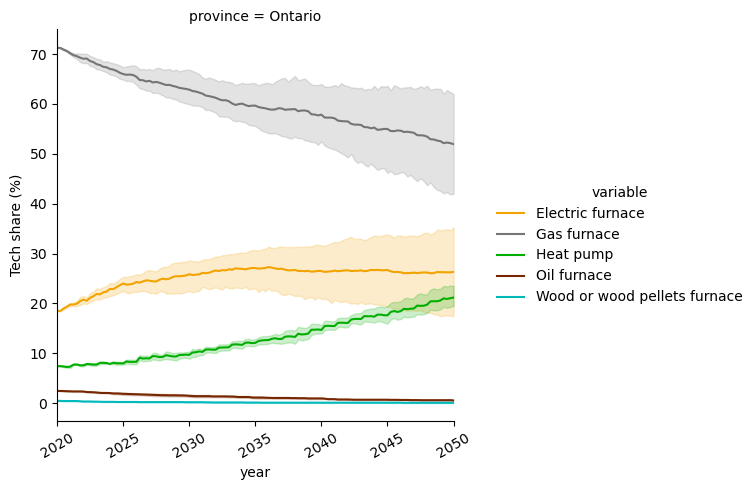

In [ ]:
tech_share_fig.fig.axes[0].set_xlim((2020, 2050))

tech_share_fig.figure

In [ ]:
import plotly.express as px
model_demand = b_res.mean_carrier_demand_df
energy_demand_df_long = model_demand.groupby(["province","year"]).sum().reset_index().melt(id_vars=["province","year"])

energy_demand_df_long["value"] = energy_demand_df_long["value"].astype(float)
energy_demand_df_long["fuel"] = energy_demand_df_long["variable"].str.split(".", expand=True)[0]

energy_demand_df_long


,province,year,variable,value,fuel
0,Ontario,2020.0,Fuels.NATURAL_GAS,9.273691e+10,Natural gas
1,Ontario,2025.0,Fuels.NATURAL_GAS,8.590769e+10,Natural gas
2,Ontario,2030.0,Fuels.NATURAL_GAS,8.188707e+10,Natural gas
3,Ontario,2035.0,Fuels.NATURAL_GAS,7.820968e+10,Natural gas
4,Ontario,2040.0,Fuels.NATURAL_GAS,7.594273e+10,Natural gas
5,Ontario,2045.0,Fuels.NATURAL_GAS,7.220131e+10,Natural gas
6,Ontario,2050.0,Fuels.NATURAL_GAS,6.811571e+10,Natural gas
7,Ontario,2020.0,Fuels.HEATING_OIL,3.261190e+09,Heating oil
8,Ontario,2025.0,Fuels.HEATING_OIL,2.498882e+09,Heating oil
9,Ontario,2030.0,Fuels.HEATING_OIL,1.852482e+09,Heating oil


In [ ]:
from abetam.figures import sciencify_plotly_fig
from abetam.config import FUEL_COLORS
fig = px.bar(
    energy_demand_df_long,
    x="year",
    y="value",
    color="fuel",
    color_discrete_map=FUEL_COLORS,
)
fig.update_layout(xaxis_title="Year", yaxis_title="Energy demand (kWh/a)", width=500, legend_traceorder="reversed")
sciencify_plotly_fig(fig)


In [ ]:
model_demand = b_res.mean_carrier_demand_df
new_demand = add_abm_demand_to_projection(model_demand)
abm_inkl_peaks = new_demand.max().reset_index()
abm_inkl_peaks[["province","year"]] = abm_inkl_peaks["index"].str.split(".",expand=True)
abm_inkl_peaks = abm_inkl_peaks.rename({0:"ABM_incl"}, axis=1).drop(["index","province"],axis=1)
abm_inkl_peaks

,ABM_incl,year
0,20153.212295,2020
1,23427.833787,2025
2,28218.998288,2030
3,34389.004031,2035
4,39840.216979,2040
5,44018.701047,2045
6,47290.178604,2050


In [ ]:
copper_demand_projection = pd.read_csv("copper/results/BAU_scenario_20240315_1125/demand_df_user_demand=False.csv")
copper_demand_projection.columns = ["year","hour"] + copper_demand_projection.columns[2:].to_list()
copper_demand_projection["Ontario"] = copper_demand_projection["Ontario.a"] + copper_demand_projection["Ontario.b"]

copper_demand_peaks = copper_demand_projection.groupby(["year"]).max()["Ontario"].reset_index()
copper_demand_peaks = copper_demand_peaks.rename({"Ontario":"COPPER projection"}, axis=1)
copper_demand_peaks.melt(id_vars="year")

,year,variable,value
0,2025,COPPER projection,23836.863269
1,2030,COPPER projection,25113.331501
2,2035,COPPER projection,26578.906183
3,2040,COPPER projection,29056.200162
4,2045,COPPER projection,30619.891274
5,2050,COPPER projection,32917.383850


In [ ]:
import plotly.express as px
from abetam.figures import sciencify_plotly_fig
both_demands = pd.concat([abm_inkl_peaks.melt(id_vars="year"),copper_demand_peaks.melt(id_vars="year")])
fig = sciencify_plotly_fig(px.line(both_demands, x="year", y="value", color="variable", template="plotly"))
fig.update_layout(yaxis_title="Peak demand (MW)") 

# Results of the coupled model

In [6]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from pathlib import Path
import pandas as pd

from abetam.figures import sciencify_plotly_fig

def copper_result_dir(abm_result_dir: Path):
    scen_date, iteration = abm_result_dir.stem.rsplit("_",1)
    result_dirs = list(Path(f"copper/results/{scen_date}").iterdir())
    result_dirs = sorted(result_dirs)
    return result_dirs[int(iteration)]

abm_result_dirs = Path("results").iterdir()
date = "20240417"
abm_result_dirs = [d for d in abm_result_dirs if date in d.name]
# abm_result_dirs
result_df = pd.DataFrame(list([(d, copper_result_dir(d)) for d in sorted(abm_result_dirs)]), columns=["ABM path", "ESM path"])
result_df["iteration"] = result_df["ABM path"].apply( lambda p: p.stem.rsplit("_",1)[-1]).astype(int)

result_df["Scenario"] = result_df["ABM path"].apply( lambda p: p.stem.split("_",1)[0])

scen_mod = result_df["ABM path"].apply(lambda p: "+" if "_plus" in p.stem else "")

result_df["Scenario"] = result_df["Scenario"] + scen_mod

result_df

,ABM path,ESM path,iteration,Scenario
0,results\BAU_20240417_0919_0,copper\results\BAU_20240417_0919\BAU_scenario_...,0,BAU
1,results\BAU_20240417_0919_1,copper\results\BAU_20240417_0919\BAU_scenario_...,1,BAU
2,results\CER_20240417_0935_0,copper\results\CER_20240417_0935\CER_scenario_...,0,CER
3,results\CER_20240417_0935_1,copper\results\CER_20240417_0935\CER_scenario_...,1,CER
4,results\CER_plus_20240417_0951_0,copper\results\CER_plus_20240417_0951\CER_scen...,0,CER+
5,results\CER_plus_20240417_0951_1,copper\results\CER_plus_20240417_0951\CER_scen...,1,CER+
6,results\Rapid_20240417_1007_0,copper\results\Rapid_20240417_1007\CER_scenari...,0,Rapid
7,results\Rapid_20240417_1007_1,copper\results\Rapid_20240417_1007\CER_scenari...,1,Rapid


In [ ]:
# # zip all the results
# from zipfile import ZipFile, ZIP_DEFLATED
# from pathlib import Path

# with ZipFile("results.zip","w", compression=ZIP_DEFLATED, compresslevel=9) as zf:
#     for path in result_df["ABM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)
#     for path in result_df["ESM path"]:
#         for f in path.rglob("*"):
#             zf.write(f, f)


In [1]:
# from zipfile import ZipFile
# from pathlib import Path

# # unzip all the results
# filenames :list[str]= []
# with ZipFile("results_240417","r") as zf:
#     file_list = zf.filelist
#     for f in file_list:
#         fn = f.filename
#         zf.extract(f,)
#         filenames.append(fn)

## ABM Adoption and energy demands

In [15]:
retrofitted_households = (335/500)*5.169*1e6
buildings_per_household = (1639581/(5.169*1e6))
retrofitted_buildings = retrofitted_households* buildings_per_household
retrofitted_households,buildings_per_household,retrofitted_buildings
retrofitted_buildings*100000/1e9

109.851927

In [16]:
from abetam.data.canada import (
    uncertain_demand_from_income_and_province,
    get_end_use_agg_heating_share
)
from abetam.components.model import get_income_and_attitude_weights

def get_demand_reductions(n):
    dem_red = np.random.normal(0.4875, 0.125, n)
    # ensure (0,1) boundaries
    dem_red[dem_red < 0] = -dem_red[dem_red < 0]
    dem_red[dem_red > 1] = 1 - (dem_red[dem_red > 1] - 1)
    return dem_red

def mean_energy_demand(n):
    province = "Ontario"
    price_weight_mode = 0.55
    start_year=2020
    income_distribution, weights_df = get_income_and_attitude_weights(
        n, price_weight_mode=price_weight_mode
    )
    total_energy_demand = uncertain_demand_from_income_and_province(
        income_distribution, province
    )

    province_heat_share = get_end_use_agg_heating_share(province, start_year)
    heat_demand = total_energy_demand * province_heat_share
    return heat_demand.mean()

def get_scenario_retrofit_cost(abm_res):
    no_refurbishments = abm_res.results_df[["RunId","AgentID","Refurbished","Heat demand"]].drop_duplicates().groupby("RunId")["Refurbished"].sum()
    assert no_refurbishments[0] == no_refurbishments.mean()

    mean_demand = mean_energy_demand(no_refurbishments[0])
    demand_frame = abm_res.results_df[["RunId","Step","AgentID","Heat demand"]].query("Step == 0")
    demand_frame["n_households"] = demand_frame["Heat demand"]/mean_demand
    demand_frame = demand_frame.groupby("RunId").sum()
    seeds = abm_res.results_df[["RunId","random_seed"]].drop_duplicates().set_index("RunId")
    seeds["n_households"] = demand_frame["n_households"]
    no_res_buildings = 1639581 #https://open.canada.ca/data/en/dataset/7803173f-8ab7-428c-b987-74bbde245e12/resource/6cc8a832-11d5-4d9a-9796-397905490dc1
    no_households = 5.169*1e6 # https://www.ontario.ca/page/ontario-demographic-quarterly-highlights-first-quarter

    households_per_building = no_households/no_res_buildings

    max_build_work_cost = 100000
    total_retrofit_costs = pd.DataFrame()
    refurbished_share = no_refurbishments[0]/abm_res.results_df["AgentID"].max()
    for r_id, seed, n_households in seeds.itertuples():
        # _, r_id, seed = tupl
        np.random.seed(seed)
        dem_reds = get_demand_reductions(no_refurbishments[0])

        # assume maximum reduction == maximum cost
        dem_reds /= dem_reds.max()
        retrofit_costs = (dem_reds*max_build_work_cost).mean()*no_households*refurbished_share/households_per_building
        # print(n_households/households_per_building)

        total_retrofit_costs.at[r_id,"Retrofit costs (CAD)"] = retrofit_costs

    total_retrofit_costs["scenario"] = scenario
    return total_retrofit_costs


get_scenario_retrofit_cost(abm_res)

,Retrofit costs (CAD),scenario
3,5.843264e+10,Rapid
1,6.103493e+10,Rapid
2,5.875905e+10,Rapid
5,5.903766e+10,Rapid
4,5.096828e+10,Rapid
0,5.220385e+10,Rapid


In [17]:
import sys 
sys.path.insert(0,"abetam")
from abetam.batch import BatchResult
import seaborn as sns

tech_share_dfs = []
fuel_demands = []
subsidy_dfs = []
emission_dfs = []
lcoh_dfs = []
spendings_dfs = []
retrofit_costs = []

for scenario in result_df.Scenario.unique():
    # print(scenario,":", result_df.query(f"iteration==1 and Scenario=='{scenario}'"))
    abm_res = BatchResult.from_directory(result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ABM path"].values[0])
    t_share_df = abm_res.tech_shares_df
    t_share_df["scenario"] = scenario
    tech_share_dfs.append(t_share_df)

    demands = abm_res.mean_carrier_demand_df.copy()
    demands["scenario"] = scenario
    fuel_demands.append(demands)

    subs = abm_res.subsidies_df
    subs["scenario"] = scenario
    subsidy_dfs.append(subs)

    emiss = abm_res.emissions()
    emiss["scenario"] = scenario
    emission_dfs.append(emiss)

    lcohs = pd.DataFrame.from_records(abm_res.results_df["LCOH"])
    lcohs[['year','RunId','AgentID',"Refurbished"]] = abm_res.results_df[['year','RunId','AgentID',"Refurbished"]]
    long_lcohs = lcohs.set_index(["year","RunId","AgentID","Refurbished"]).melt(ignore_index=False).reset_index().drop("AgentID", axis=1)
    long_lcohs = long_lcohs.round(2).drop_duplicates().groupby(["year","variable"]).mean().reset_index()
    long_lcohs["scenario"] = scenario
    lcoh_dfs.append(long_lcohs)

    adopt_df = abm_res.adoption_details_df.set_index(['RunId','AgentID','year',])
    adopt_df["req. size"] = abm_res.results_df[['RunId','AgentID','year','Required heating size']].set_index(['RunId','AgentID','year']).loc[adopt_df.index,'Required heating size']
    adopt_df["Purchase cost"] = adopt_df["purchase_price"] * adopt_df["req. size"]
    total_spendings = adopt_df.groupby(["RunId", "tech"])["Purchase cost"].sum().groupby("tech").mean().reset_index()
    total_spendings["scenario"] = scenario
    spendings_dfs.append(total_spendings)

    retrofit_costs.append(get_scenario_retrofit_cost(abm_res))

scenario_tech_shares = pd.concat(tech_share_dfs)
scenario_fuel_demands = pd.concat(fuel_demands)
scenario_emissions = pd.concat(emission_dfs)
scenario_subsidies = pd.concat(subsidy_dfs)
scenario_lcohs = pd.concat(lcoh_dfs)
scenario_spendings = pd.concat(spendings_dfs)
scenario_retrofit_costs = pd.concat(retrofit_costs)

scenario_emissions.head()


,Fuels.ELECTRICITY,Fuels.HEATING_OIL,Fuels.NATURAL_GAS,Fuels.WOOD_OR_WOOD_PELLETS,scenario
2020,0.458514,1.580805,18.60692,0.092339,BAU
2021,0.464824,1.504949,18.42428,0.085757,BAU
2022,0.471133,1.429094,18.24164,0.079175,BAU
2023,0.477443,1.353238,18.05900,0.072593,BAU
2024,0.483752,1.277383,17.87636,0.066011,BAU


In [25]:
import plotly.express as px

rtrft_fig = px.box(scenario_retrofit_costs, x="scenario",y="Retrofit costs (CAD)", color="scenario", template="plotly", width=400,)
rtrft_fig = sciencify_plotly_fig(rtrft_fig)
rtrft_fig.update_layout(showlegend=False, margin=dict(r=10,t=10,b=10), height=350, font_family="cm",font_size=18)
rtrft_fig.write_image("abm_retrofit_cost.svg")
rtrft_fig.write_image("abm_retrofit_cost.pdf",engine="kaleido")
rtrft_fig

In [27]:
scenario_fuel_demands_long = scenario_fuel_demands.groupby(["year","scenario"]).sum().melt(ignore_index=False).reset_index()
scenario_fuel_demands_long["value"] /= 1e9 # kWh -> TWh
# scenario_fuel_demands_long.query("year>2049")
scenario_fuel_demands_long.query("year<2021")

,year,scenario,variable,value
0,2020.0,BAU,Fuels.NATURAL_GAS,93.034599
1,2020.0,CER,Fuels.NATURAL_GAS,92.775458
2,2020.0,CER+,Fuels.NATURAL_GAS,92.637958
3,2020.0,Rapid,Fuels.NATURAL_GAS,92.092811
28,2020.0,BAU,Fuels.HEATING_OIL,3.161609
29,2020.0,CER,Fuels.HEATING_OIL,3.103995
30,2020.0,CER+,Fuels.HEATING_OIL,3.150111
31,2020.0,Rapid,Fuels.HEATING_OIL,3.128697
56,2020.0,BAU,Fuels.WOOD_OR_WOOD_PELLETS,0.615591
57,2020.0,CER,Fuels.WOOD_OR_WOOD_PELLETS,0.615591


In [5]:
from abetam.config import TECHNOLOGY_COLORS, FUEL_COLORS
from abetam.components.technologies import Fuels
ABM_colors = dict(TECHNOLOGY_COLORS, **FUEL_COLORS)

scenario_tech_shares_long = scenario_tech_shares.drop(["province","RunId"], axis=1).melt(id_vars=["year","scenario"]) 
abm_results = pd.concat([scenario_tech_shares_long, scenario_fuel_demands_long])
def is_fuel(v):
    return v in list(Fuels)
abm_results["is_demand"] = abm_results["variable"].apply(is_fuel)

abm_results["variable"] = abm_results["variable"].str.replace("Wood or wood pellets", "Biomass")
ABM_colors["Biomass furnace"] = ABM_colors["Wood or wood pellets furnace"]
ABM_colors["Biomass"] = ABM_colors["Wood or wood pellets"]
abm_results.tail()



,year,scenario,variable,value,is_demand
107,2045.0,Rapid,Electricity,18.080887,True
108,2050.0,BAU,Electricity,51.067027,True
109,2050.0,CER,Electricity,44.909346,True
110,2050.0,CER+,Electricity,59.909489,True
111,2050.0,Rapid,Electricity,18.092214,True


0 False BAU 3630
1 False CER 3630
2 False CER+ 3630
3 False Rapid 3630
4 True BAU 28
5 True CER 28
6 True CER+ 28
7 True Rapid 28


[]

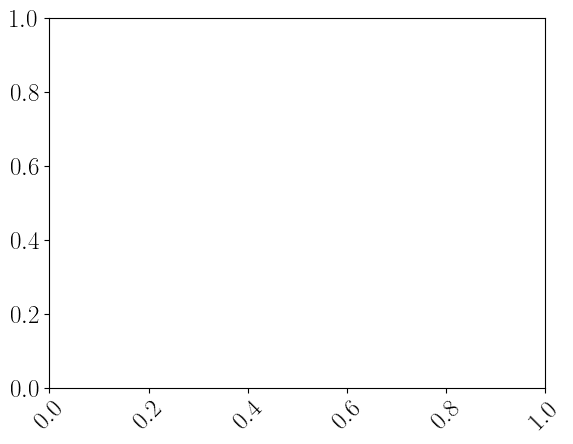

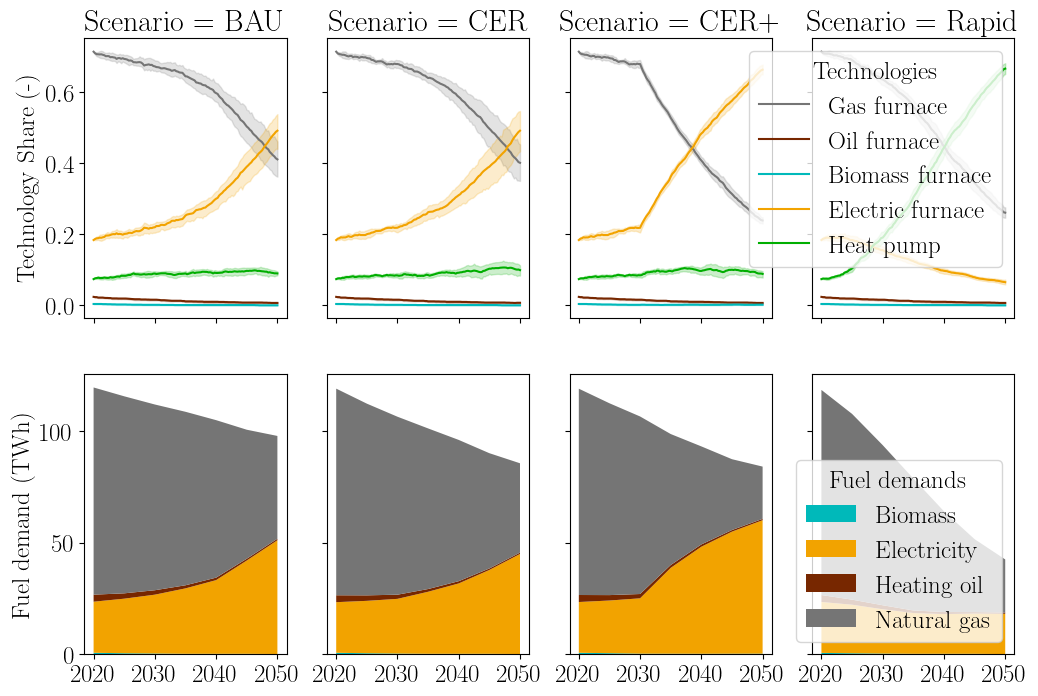

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "cm"
plt.rcParams["font.size"] = "18"
plt.rcParams['svg.fonttype'] = 'none'

plt.xticks(rotation=45)
fuel_name_map = dict(zip(Fuels, [x.value for x in Fuels]))
fuel_name_map["Biomass"] = "Biomass"

abm_fig, axs = plt.subplots(ncols=4, nrows=2,  sharex='all', sharey='row', figsize=(12,8))
for i,(dem_scen, df) in enumerate(abm_results.groupby(["is_demand","scenario"])):
    print(i,dem_scen[0],dem_scen[1],len(df))
    ax = axs.flat[i]
    if not dem_scen[0]:
        ax.title.set_text(f"Scenario = {dem_scen[1]}")
        show_legend = i==3
        sns.lineplot(data=df, x="year", y="value", hue="variable", palette=ABM_colors, ax=ax, legend=show_legend)
        if show_legend:
            ax.get_legend().set_title("Technologies")
    else:
        show_legend = i==7
        wide_df = df.pivot(columns="variable", values="value", index="year")
        wide_columns = wide_df.columns
        column_vals = [wide_df[col].astype(float) for col in wide_columns]
        ax.stackplot(wide_df.index, *column_vals, colors=[ABM_colors[col] for col in wide_columns], labels=[fuel_name_map[col] for col in wide_columns])
        if show_legend:
            ax.legend(loc="lower right")
            ax.get_legend().set_title("Fuel demands")


abm_fig.axes[0].set_ylabel("Technology Share (-)")
abm_fig.axes[4].set_ylabel("Fuel demand (TWh)")
abm_fig.axes[0].set_xticks(range(2020,2051,10))
abm_fig.axes[0].set_xticklabels(range(2020,2051,10))


## ABM: Emissions and subsidies

In [7]:
total_scenario_emissions = scenario_emissions.reset_index().groupby(["index","scenario"]).sum().sum(axis=1).reset_index()
total_scenario_emissions["cumulative"] = total_scenario_emissions.groupby("scenario").cumsum()[0]
# px.line(total_scenario_emissions, x="index", y="cumulative", color="scenario", template="plotly")

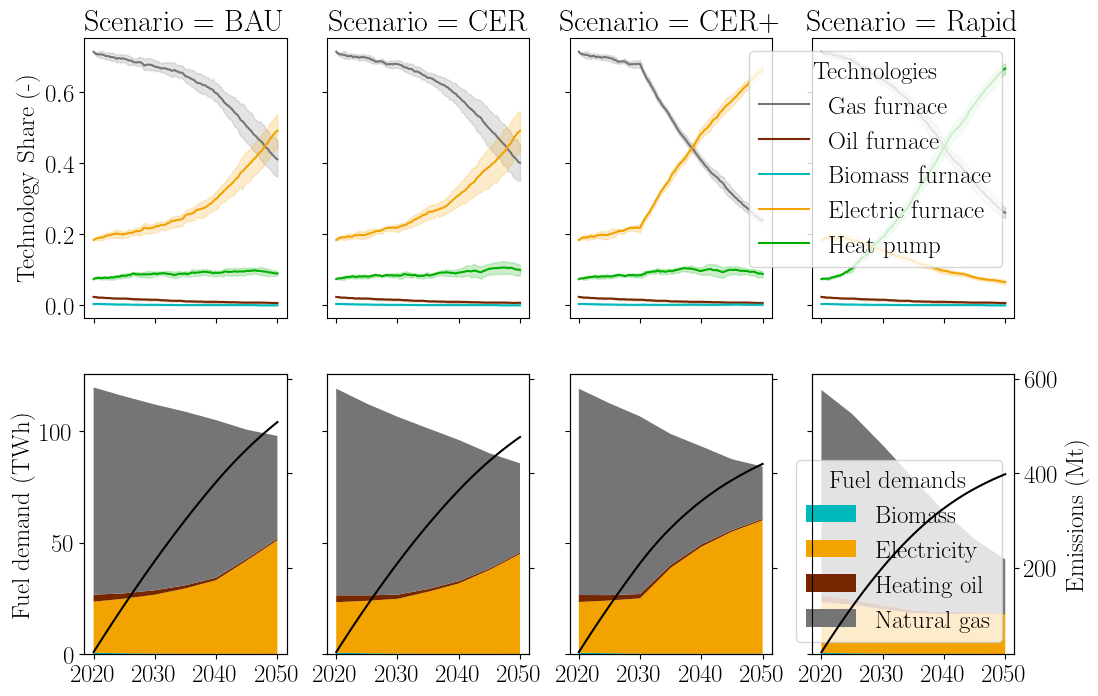

In [8]:
em_y_lim = total_scenario_emissions.cumulative.min()*0.8, total_scenario_emissions.cumulative.max()*1.2
emission_color = "black"
for i, (scen, df) in enumerate(total_scenario_emissions.groupby("scenario")):
    # print(scen, df)
    t_ax = axs.flat[4+i].twinx()
    t_ax.plot(df["index"],df["cumulative"], color=emission_color)
    t_ax.set_ylim(*em_y_lim)
    t_ax.spines["right"].set_color(emission_color)
    t_ax.tick_params(colors=emission_color, which='both')
    last = i==3
    if not last:
        t_ax.set_yticklabels([])
    else:
        t_ax.set_ylabel("Emissions (Mt)")
abm_fig.savefig("abm_results.svg")
abm_fig

In [9]:
import plotly.express as px
subsidies_plot_df = scenario_subsidies.groupby(["year","scenario"])[["hp specific cost", "Cumulative subsidy amount (CAD)"]].mean()
px.line(subsidies_plot_df.reset_index(), x="year", y=["Cumulative subsidy amount (CAD)","hp specific cost"], color="scenario", template="plotly", width=600)

In [92]:
scenario_spendings["tech"] = scenario_spendings["tech"].str.replace("Wood or wood pellets", "Biomass")


In [100]:
fig = sciencify_plotly_fig(
    px.bar(
        scenario_spendings,
        x="scenario",
        y="Purchase cost",
        color="tech",
        color_discrete_map=ABM_colors,
    )
)
fig.update_layout(
    yaxis_title="Total spendings (CAD)",
    xaxis_title="",
    legend=dict(
        title_text="Technologies",
        # bgcolor="LightSteelBlue",
        bordercolor="gray",
        borderwidth=2,
        x=0.02,
        y=0.98,
        traceorder="reversed",
    ),
    width=500,
    font_family="cm",
    font_size=18
)
fig.write_image("abm_total_spendings.pdf")
fig.write_image("abm_total_spendings.svg")
fig

In [10]:
total_emissions = total_scenario_emissions.groupby("scenario")[0].sum()
avoided_emissions = total_emissions["BAU"] - total_emissions
total_subsidies = subsidies_plot_df.loc[2050,"Cumulative subsidy amount (CAD)"]*1e-6
carbon_avoidance_cost = total_subsidies/avoided_emissions

summary_df = pd.concat(
    [total_emissions, total_subsidies, avoided_emissions, carbon_avoidance_cost],
    axis=1,
).fillna(0).round(2)
summary_df.columns = ["Total emissions (Mt)","Total subsidies (MCAD)","Avoided emissions (Mt)","Carbon avoidance cost (CAD/t)",]
print(summary_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Total emissions (Mt) & Total subsidies (MCAD) & Avoided emissions (Mt) & Carbon avoidance cost (CAD/t) \\
scenario &  &  &  &  \\
\midrule
BAU & 508.120000 & 0.000000 & 0.000000 & 0.000000 \\
CER & 476.460000 & 768.540000 & 31.660000 & 24.270000 \\
CER+ & 419.530000 & 745.650000 & 88.590000 & 8.420000 \\
Rapid & 397.750000 & 8082.010000 & 110.370000 & 73.230000 \\
\bottomrule
\end{tabular}



## ABM: LCOH

In [104]:
scenario_lcohs.pivot(columns="scenario", index=["year","variable"], values="value").query("variable=='Heat pump'")

,scenario,BAU,CER,CER+,Rapid
year,variable,,,,
2020.00,Heat pump,0.078571,0.076667,0.076667,0.068000
2020.25,Heat pump,0.078571,0.076667,0.076667,0.071818
2020.50,Heat pump,0.078571,0.076667,0.076667,0.072174
2020.75,Heat pump,0.078571,0.076667,0.076667,0.072500
2021.00,Heat pump,0.076667,0.075000,0.075000,0.071429
...,...,...,...,...,...
2049.00,Heat pump,0.072000,0.070000,0.070323,0.066452
2049.25,Heat pump,0.072000,0.070625,0.070323,0.066452
2049.50,Heat pump,0.072000,0.070625,0.070323,0.066452


In [99]:
scenario_lcohs["variable"] = scenario_lcohs["variable"].str.replace("Wood or wood pellets", "Biomass")
fig = sciencify_plotly_fig(
    px.line(
        scenario_lcohs.query("scenario=='BAU'"),
        x="year",
        y="value",
        color="variable",
        facet_col="scenario",
        template="plotly",
        color_discrete_map=ABM_colors,
        width=500
    )
)
fig.update_layout(
    yaxis_title="LCOH (CAD/kWh)",
    legend=dict(
        title_text="Technologies",
        bordercolor="gray",
        borderwidth=2,
        x=0.3,
        y=0.88,
        traceorder="reversed",
    ),
    width=500,
    font_family="cm",
    font_size=18
)
fig.write_image("abm_lcoh.svg")
fig.write_image("abm_lcoh.pdf")
fig

In [14]:
(res_df['Heat demand']/res_df['Required heating size']).unique()

array([2575.31549674, 2575.31549674, 2575.31549674])

## Copper: demands/supplied energy

In [29]:
from copper.phases.postprocessing import get_all_supply

total_demand_dfs = []
peak_demand_dfs = []
supply_dfs = []
supply_share_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    sup_df = get_all_supply(path)

    total_demand = sup_df.groupby(["pds"])[["value"]].sum().reset_index()
    total_demand["scenario"] = scenario
    total_demand_dfs.append(total_demand)
    
    peak_demand = sup_df.groupby(["pds","h"])[["value"]].sum().reset_index().groupby("pds").max().reset_index().drop("h", axis=1)
    peak_demand["scenario"] = scenario
    peak_demand_dfs.append(peak_demand)

    supply_share_by_type = sup_df.groupby(["pds","Type"]).sum()/sup_df.groupby(["pds"]).sum()
    is_supply = supply_share_by_type.reset_index()["value"] > 0
    supply_share_by_type = supply_share_by_type.reset_index().loc[is_supply,:]
    supply_share_by_type["scenario"] = scenario
    supply_share_dfs.append(supply_share_by_type)
    
    sup_df["scenario"] = scenario
    supply_dfs.append(sup_df)

scen_supply_df = pd.concat(supply_dfs)
scen_total_demand_df = pd.concat(total_demand_dfs)    
scen_peak_demand_df = pd.concat(peak_demand_dfs)
scen_supply_share_df = pd.concat(supply_share_dfs)    

In [19]:
scen_total_demand_df.pivot(columns="scenario", index="pds", values="value")

scenario,BAU,CER,CER+,Rapid
pds,,,,
2025,4.818736e+06,4.584419e+06,4.588991e+06,4.522350e+06
2030,5.928501e+06,5.646503e+06,5.657720e+06,5.447809e+06
2035,7.695908e+06,8.303936e+06,8.999067e+06,8.171869e+06
2040,9.379522e+06,1.080893e+07,1.161011e+07,1.068345e+07
2045,1.103340e+07,1.341912e+07,1.454677e+07,1.345434e+07
2050,1.238212e+07,1.551821e+07,1.645162e+07,1.579541e+07


In [32]:
from viz.copper import tech_agg

def get_nice_tech_name(key):
    try:
        nice_name = tech_agg[key]
    except KeyError as ke:
        nice_name = key
    
    return nice_name


scen_supply_share_df["Generator"] = scen_supply_share_df.Type.apply(get_nice_tech_name)
scen_supply_share_df = scen_supply_share_df.groupby(["pds","Generator","scenario"])[["value"]].sum().reset_index()


AttributeError: 'DataFrame' object has no attribute 'Type'

In [33]:
scen_supply_share_df.query("pds==2050").pivot(columns="scenario",index="Generator",values="value")

scenario,BAU,CER,CER+,Rapid
Generator,,,,
Biomass,NaN,NaN,0.001103,0.000683
Fossil fuel gas,0.157885,0.006597,0.007020,NaN
Hydro,0.028276,0.024790,0.023545,0.022814
Hydrogen - blue,NaN,0.038994,0.040919,NaN
Hydrogen - green,NaN,NaN,NaN,0.000682
Nuclear,0.066472,0.048676,0.045585,0.065759
Solar,0.051465,0.085600,0.088390,0.069355
Wind,0.695903,0.795344,0.793438,0.840707


In [21]:
import plotly.express as px
from abetam.figures import sciencify_plotly_fig
from viz.copper import IDEA_COLORS

gen_sharefig = px.area(scen_supply_share_df, x="pds", y="value", color="Generator", facet_col="scenario", template="plotly", width=900, color_discrete_map=IDEA_COLORS)
gen_sharefig.for_each_trace(lambda trace: trace.update(fillcolor = trace.line.color, line_width=0))
gen_sharefig = sciencify_plotly_fig(gen_sharefig)
gen_sharefig = gen_sharefig.update_layout(
    yaxis_title="Generation share (-)",
    xaxis1_title="year",
    xaxis2_title="year",
    xaxis3_title="year",
)

In [22]:
# # scale with no. rundays
# scen_total_demand_df["value"] *= 365/12
# # px.line(scen_total_demand_df, x="pds", y="value", color="scenario", template="plotly", width=700)

In [23]:
# scen_peak_demand_df["demand_type"] = "Peak demand"
# scen_total_demand_df["demand_type"] = "Total demand"
# fig = px.line(pd.concat([scen_peak_demand_df, scen_total_demand_df]), x="pds", y="value", color="scenario", facet_row="demand_type", template="plotly", width=600)
# fig = fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.update_yaxes(matches=None)

In [34]:
import plotly.express as px

# total_demand["h"] = total_demand["h"].astype("str")
#px.line(total_demand, x="h", y="value", color="pds", template="plotly")

## Copper installed capacity

In [36]:
from viz.copper import tech_agg
import pandas as pd
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)
def get_capacity_frame(results_dir):
    capacitiy_files = list(Path(results_dir).glob("capacity_*"))
    generation_dfs = []
    therm_df = None
    transmission_df = None
    storage_df = None
    for f in capacitiy_files:
        if "transmission" in f.as_posix():
            transmission_df = pd.read_csv(f)
            assert transmission_df["value"].sum() == 0
        elif "storage" in f.as_posix():
            storage_df = pd.read_csv(f).rename({"st":"type"}, axis=1)
            storage_df["gl"] = None
            generation_dfs.append(storage_df)
        else:
            df = pd.read_csv(f)
            gen_type = f.stem.split("_",1)[-1]
            if "tplants" in df.columns:
                therm_df = df.copy()
                df = df.rename({"tplants":"type"}, axis=1)
                df["gl"] = None
            else:
                df["type"] = gen_type
                df["aba"] = df["gl"].apply(map_gl_to_ba.get)
            # print(gen_type, df.columns)
            generation_dfs.append(df)
    gen_cap_df = pd.concat(generation_dfs)
    return gen_cap_df

def get_capacity_frame(results_dir):
    capacitiy_files = list(Path(results_dir).glob("capacity_*"))
    generation_dfs = []
    therm_df = None
    transmission_df = None
    storage_df = None
    for f in capacitiy_files:
        if "transmission" in f.as_posix():
            transmission_df = pd.read_csv(f)
            assert transmission_df["value"].sum() == 0
        elif "storage" in f.as_posix():
            storage_df = pd.read_csv(f).rename({"st":"type"}, axis=1)
            storage_df["gl"] = None
            generation_dfs.append(storage_df)
        else:
            df = pd.read_csv(f)
            gen_type = f.stem.split("_",1)[-1]
            if "tplants" in df.columns:
                therm_df = df.copy()
                df = df.rename({"tplants":"type"}, axis=1)
                df["gl"] = None
            else:
                df["type"] = gen_type
                df["aba"] = df["gl"].apply(map_gl_to_ba.get)
            # print(gen_type, df.columns)
            generation_dfs.append(df)
    gen_cap_df = pd.concat(generation_dfs)
    return gen_cap_df

def simplify_unit_name(name, use_idea=False):
    if use_idea:
        return tech_agg.get(name)
    split = name.rsplit("_", 1)
    if len(split) == 1:
        return name

    head, tail = split
    if tail in ["SMR", "ofs", "ons", "LI", "PH"]:
        return name
    elif "_recon" in head:
        return head.rsplit("_", 1)[0]
    elif "gas" in head:
        if "retire" in head:
            return "gas_retire"
        elif "backup" in head:
            return "gas_backup"
        else:
            return "gas"
    else:
        return head

def post_process_gen_cap(gen_cap_df, use_idea=False):
    
    gen_cap_df["Generator"] = gen_cap_df.type.apply(simplify_unit_name, use_idea=use_idea)
    gen_cap_df["province"] = gen_cap_df["aba"].str.split(".", expand=True)[0]
    ba_cap_df = (
        gen_cap_df.groupby(["province", "pds", "Generator"])["value"].sum().reset_index()
    )

    # remove generators that aren't built
    keep_types = ba_cap_df.groupby(["pds", "Generator"])["value"].sum() > 0

    keep_types = keep_types  # & keep_names
    ba_cap_df = ba_cap_df.set_index(["pds", "Generator"]).loc[keep_types, :].reset_index()

    ba_cap_df["type"] = ba_cap_df["Generator"]
    keep_names = ~ba_cap_df.set_index(["pds", "Generator"])["type"].str.contains("retire")
    ba_cap_df.set_index(["pds", "Generator"], inplace=True)
    ba_cap_df.loc[keep_names, "cap_type"] = "invested"
    ba_cap_df.loc[~keep_names, "cap_type"] = "retired"

    ba_cap_df.reset_index(inplace=True)
    ba_cap_df.rename({"value": "Capacity (GW)"}, axis=1, inplace=True)
    ba_cap_df["Capacity (GW)"] /= 1000
    return ba_cap_df



In [37]:
def get_sign(t):
    if "retire" in t:
        return -1
    else:
        return 1

cap_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")["ESM path"].values[0]
    cap_df = get_capacity_frame(path)
    ba_cap_df = post_process_gen_cap(cap_df, use_idea=True)
    ba_cap_df["Capacity (GW)"] *= ba_cap_df["Generator"].apply(get_sign)
    ba_cap_df["scenario"] = scenario
    cap_dfs.append(ba_cap_df)

cap_df = pd.concat(cap_dfs)

C:\Users\dhuck\AppData\Local\Temp\ipykernel_35004\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\dhuck\AppData\Local\Temp\ipykernel_35004\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\dhuck\AppData\Local\Temp\ipykernel_35004\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'invested' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\dhuck\AppData\Local\Temp\ipykernel_35004\212783144.py:102: FutureWarning:

Setting an item of incompatible dtype is deprecated and

In [52]:
cum_cap_df = cap_df.groupby(["scenario","Generator"])["Capacity (GW)"].sum().reset_index().pivot(columns="scenario",index="Generator",values="Capacity (GW)").fillna(0)
cum_cap_df

scenario,BAU,CER,CER+,Rapid
Generator,,,,
Biomass,0.000000,0.000000,0.245300,0.245300
Fossil fuel gas,25.917605,6.969377,7.862588,0.000000
Fossil fuel gas - retired,-8.210800,-5.167800,-5.167800,-6.989800
Hydrogen - blue,0.000000,14.007401,15.582892,0.000000
Hydrogen - green,0.000000,0.000000,0.000000,1.284574
LI Storage,3.202693,0.112728,0.010008,12.093589
Nuclear,0.000000,0.000000,0.000000,5.707564
PH Storage,0.283600,0.283600,0.283600,0.283600
Solar,12.417352,26.204898,28.642777,22.116980


In [60]:
((cum_cap_df["Rapid"] - cum_cap_df["BAU"])/cum_cap_df["BAU"]*100).reset_index()

,Generator,0
0,Biomass,inf
1,Fossil fuel gas,-1.000000e+02
2,Fossil fuel gas - retired,-1.487066e+01
3,Hydrogen - blue,NaN
4,Hydrogen - green,inf
5,LI Storage,2.776069e+02
6,Nuclear,inf
7,PH Storage,-3.719012e-13
8,Solar,7.811349e+01
9,Wind,7.634679e+01


In [27]:
from abetam.figures import sciencify_plotly_fig
import plotly.express as px
scen_cap_fig = sciencify_plotly_fig(px.bar(cap_df, x="pds", y="Capacity (GW)", color="Generator", facet_col="scenario", color_discrete_map=IDEA_COLORS))


### Emissions


In [115]:
import toml
def get_year_frac(res_path:Path):
    config = toml.load(res_path.joinpath("config.toml"))
    year_frac = len(config["Simulation_Settings"]["run_days"])/365
    return year_frac

result_df["ESM year_frac"] = result_df["ESM path"].apply(get_year_frac)

if len(result_df["ESM year_frac"].unique())>1:
    def add_year_frac(scen_name):
        frac = result_df.query(f"Scenario=='{scen_name}' and iteration==1")["ESM year_frac"]
        return frac
    scen_supply_df["year_frac"] = scen_supply_df["scenario"].apply(add_year_frac)
else:
    scen_supply_df["year_frac"] = result_df["ESM year_frac"][0]
gen_type_df = pd.read_csv("copper/scenarios/CER_scenario/generation_type_data.csv", index_col=0)
scen_supply_df["emissions (Mt)"] = (scen_supply_df["value"]/scen_supply_df["year_frac"]*gen_type_df["fuel_co2"]) / 1e6
scen_supply_agg = scen_supply_df.groupby(["scenario","pds"])["emissions (Mt)"].sum().groupby("scenario").cumsum().reset_index()
scen_supply_agg

,scenario,pds,emissions (Mt)
0,BAU,2025,3.102245
1,BAU,2030,10.006107
2,BAU,2035,20.350349
3,BAU,2040,34.078253
4,BAU,2045,52.193434
5,BAU,2050,72.410879
6,CER,2025,0.566818
7,CER,2030,3.874534
8,CER,2035,5.929980
9,CER,2040,7.203744


In [142]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

nb_rows = 2  # the number of rows in your plot
nb_cols = 4  # the number of columns in your plot
copper_fig = make_subplots(
    rows=nb_rows,
    cols=nb_cols,
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=("BAU", "CER", "CER+", "Rapid"),
    specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}],
            [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]])


legend_entries = []
for i, data in enumerate(gen_sharefig.data):
    xax = data["xaxis"].replace("x", "")
    xax = 1 if xax == "" else int(xax)
    data["legendgroup"] = "gentechs"
    data["legendgrouptitle_text"] = "Technologies"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=1, secondary_y=False)

for i, (scen, emission_data) in enumerate(scen_supply_agg.groupby("scenario")):
    xax=i+1
    copper_fig.add_trace(
        go.Scatter(x=emission_data["pds"], y=emission_data["emissions (Mt)"], mode='lines', showlegend=False),
        col=xax,
        row=1,
        secondary_y=True
    )

for i, data in enumerate(scen_cap_fig.data):
    xax = data["xaxis"].replace("x", "")
    xax = 1 if xax == "" else int(xax)
    data["legendgroup"] = "gentechs"
    # data["legendgrouptitle_text"] = "Generators"
    name = data["name"]
    show_legend = name not in legend_entries
    if show_legend:
        legend_entries.append(name)
    data["showlegend"] = show_legend
    copper_fig.add_trace(data, col=xax, row=2)


#dir(yax)=['anchor', 'automargin', 'autorange', 'autotypenumbers', 'calendar', 'categoryarray', 'categoryarraysrc', 'categoryorder', 'color', 'constrain', 'constraintoward', 'dividercolor', 'dividerwidth', 'domain', 'dtick', 'exponentformat', 'figure', 'fixedrange', 'gridcolor', 'griddash', 'gridwidth', 'hoverformat', 'layer', 'linecolor', 'linewidth', 'matches', 'minexponent', 'minor', 'mirror', 'nticks', 'on_change', 'overlaying', 'parent', 'plotly_name', 'pop', 'position', 'range', 'rangebreakdefaults', 'rangebreaks', 'rangemode', 'scaleanchor', 'scaleratio', 'separatethousands', 'showdividers', 'showexponent', 'showgrid', 'showline', 'showspikes', 'showticklabels', 'showtickprefix', 'showticksuffix', 'side', 'spikecolor', 'spikedash', 'spikemode', 'spikesnap', 'spikethickness', 'tick0', 'tickangle', 'tickcolor', 'tickfont', 'tickformat', 'tickformatstopdefaults', 'tickformatstops', 'ticklabelmode', 'ticklabeloverflow', 'ticklabelposition', 'ticklabelstep', 'ticklen', 'tickmode', 'tickprefix', 'ticks', 'tickson', 'ticksuffix', 'ticktext', 'ticktextsrc', 'tickvals', 'tickvalssrc', 'tickwidth', 'title', 'titlefont', 'to_plotly_json', 'type', 'uirevision', 'update', 'visible', 'zeroline', 'zerolinecolor', 'zerolinewidth']

def y_ax_fmt(yax):
    yax.showgrid = False
    yax.matches = "y2"
    yax.showticklabels = yax["overlaying"] == "y7"
    yax.rangemode = "tozero"
    if yax.showticklabels:
        yax.title = "Emissions (Mt)"

copper_fig.for_each_yaxis(y_ax_fmt, row=1, secondary_y=True)   
copper_fig.for_each_yaxis(lambda yax: yax.update(matches="y", showticklabels=yax.plotly_name=="yaxis"), row=1, secondary_y=False)
copper_fig.for_each_yaxis(lambda yax: yax.update(matches="y9", showticklabels=yax.plotly_name=="yaxis9"), row=2, secondary_y=False)

sciencify_plotly_fig(copper_fig)

copper_fig.update_layout(
    barmode="relative",
    width=900,
    height=600,
    yaxis1_title="Generation share (-)",
    yaxis9_title="Modified Capacity (GW)",
    xaxis5_title="Year",
    xaxis6_title="Year",
    xaxis7_title="Year",
    xaxis8_title="Year",
    font_family="cm",
    font_size=18,
    legend_traceorder="reversed",
)
copper_fig.write_image("copper_results.svg")
copper_fig


In [34]:
scen_demands = ((scen_supply_df["value"]/scen_supply_df["year_frac"]).groupby(["pds","scenario","Type"]).sum()*1e-6).reset_index() # MWh -> TWh
scen_demands.pivot(columns="scenario",index=["pds","Type"], values=0)

scenario                            BAU         CER        CER+       Rapid
pds  Type                                                                  
2025 biomass                   0.000000    0.000000    0.000000    0.000000
     coal_ccs_pre2025          0.000000    0.000000    0.000000    0.000000
     coal_pre2025              0.000000    0.000000    0.000000    0.000000
     coal_retire_pre2025       0.000000    0.000000    0.000000    0.000000
     diesel_backup_post2025    0.000000    0.000000    0.000000    0.000000
...                                 ...         ...         ...         ...
2050 nuclear                  25.034866   22.975523   22.810749   29.829583
     nuclear_SMR               0.000000    0.000000    0.000000    1.763939
     solar                    19.382715   40.404475   44.230549   33.321282
     wind_ofs                  0.000000    0.000000    0.000000    0.000000
     wind_ons                262.092805  375.411832  397.039237  403.912326

[258 rows x 4 columns]

## Alternative price derivation method
Using LCOE based approach

In [42]:
import toml
config = toml.load(open("copper/scenarios/BAU_scenario/config.toml","r"))
discount = config["Economics"]["discount"]
discount_2050 = config["Economics"]["discount_2050"]
pds = config["Simulation_Settings"]["pds"]
# pds = [int(PD) for PD in config["Simulation_Settings"]["pds"]]

inflation = config["Economics"]["inflation"]


def get_disc_coeff(PD):
    ind = pds.index(PD)
    if ind != (len(pds)-1):
        #We use disc_ann_coef as the coeffecient to bring an n-year series Annuity to a net present value
        first_term = (1/(1+discount)**(int(pds[ind+1])-int(PD)))
        second_term = 1
        third_term = discount
        disc_ann_coef = ((second_term - first_term) / third_term)
        # print(PD, f"{disc_ann_coef=}")
        if (disc_ann_coef < 0):
            # print(disc_ann_coef)
            sys.exit()
        weird_factor = (1/(1+discount)**((int(PD)-1)-2021))
        # print(PD, f"{weird_factor=}")
        # print(weird_factor)
        disc_coef = disc_ann_coef * weird_factor #New, we are using annuity series combined with future value to present value formula
    else:
        disc_coef=(1/(1+discount_2050)**(int(PD)-2021))

    # print(PD, f"{disc_coef=}")
    return disc_coef

def inf_coeff(PD):
    return (1+inflation)**(int(PD)-2021)

disc_coeffs = {PD:get_disc_coeff(PD) for PD in pds}
disc_coeffs

{'2025': 4.016778455471785,
 '2030': 3.343079163194959,
 '2035': 2.7823735900006517,
 '2040': 2.3157102827725193,
 '2045': 1.9273163506907516,
 '2050': 9.962876596086617e-05}

# Copper results

* underlying data is already annuitized and inflation adjusted
* variable costs are scaled up to represent annual cost
* fixed cost are in $/a


## System costs

In [43]:
import toml
import pandas as pd
# from main import get_copper_el_prices, multi_index_copper_demand
from copper.phases.postprocessing import get_all_disc_coeffs
import plotly.express as px

scenario = "CER_scenario"
result_dirs = [
    "copper/results/CER_20240408_1526/CER_scenario_20240408_1540"
]

results_dir = result_dirs[0]
config_path = f"{results_dir}/config.toml"
config = toml.load(config_path)
gridcell_data = pd.read_csv('copper/scenarios/static/gridcells.csv')
map_gl_to_ba=dict(gridcell_data[['grid_cell', 'ba']].values)

disc_coeffs = get_all_disc_coeffs(config)




In [44]:
disc_coeff_series = pd.Series(disc_coeffs).to_frame()
disc_coeff_series.columns = ["dual_price"]
disc_coeff_series.index.set_names(["year"], inplace=True)
disc_coeff_series.index = disc_coeff_series.index.astype(int)

In [45]:
import plotly.express as px
def uncumulate_values(df:pd.DataFrame):
    diff = df[["value"]].diff()
    df.loc[df.pds > 2025,"value"] = diff.loc[df.pds>2025,"value"].values
    df.loc[df["value"]<0,"value"] = 0
    return df


def copper_total_cost_df(result_dir, uncumulate=False):
    cap_cost = pd.read_csv(f"{result_dir}/capcost.csv")
    cap_cost["cost"] = "Invest"
    fom_cost = pd.read_csv(f"{result_dir}/fixOMcost.csv")
    fom_cost["cost"] = "FOM"
    vom_cost = pd.read_csv(f"{result_dir}/varOMcost.csv")
    vom_cost["cost"] = "VOM"
    fuel_cost = pd.read_csv(f"{result_dir}/fuel_cost.csv")
    fuel_cost["cost"] = "Fuels"
    storage_cost = pd.read_csv(f"{result_dir}/newstorage_ccost.csv")
    storage_cost["cost"] = "Storage Invest"
    storage_om_cost = pd.read_csv(f"{result_dir}/newstorage_omcost.csv")
    storage_om_cost["cost"] = "Storage OM"
    hydro_cost = pd.read_csv(f"{result_dir}/hydrorenewalccost.csv")
    hydro_cost["cost"] = "Hydro"
    hydro_om_cost = pd.read_csv(f"{result_dir}/hydrorenewalomcost.csv")
    hydro_om_cost["cost"] = "Hydro"
    if uncumulate:
        cap_cost = uncumulate_values(cap_cost)
        fom_cost = uncumulate_values(fom_cost)
        storage_cost = uncumulate_values(storage_cost)
        storage_om_cost = uncumulate_values(storage_om_cost)
        hydro_cost = uncumulate_values(hydro_cost)
        hydro_om_cost = uncumulate_values(hydro_om_cost)

    total_cost = pd.concat([cap_cost, vom_cost, fom_cost,fuel_cost,storage_cost,storage_om_cost,hydro_cost,hydro_om_cost])
    return total_cost   

total_cost = copper_total_cost_df(results_dir, uncumulate=False)
total_cost["cost_type"] = "undiscounted"
total_adapted_cost = total_cost.copy()
total_adapted_cost["cost_type"] = "discounted"
total_adapted_cost["value"] = total_cost["value"] * total_cost["pds"].astype(str).apply(disc_coeffs.get)

total_cost = pd.concat([total_cost, total_adapted_cost])

# total_cost
fig = px.bar(total_cost, x="pds", y="value",color="cost", facet_row="cost_type", template="plotly")
fig.update_layout(width=700, legend_traceorder="reversed")
fig.write_html(f"{results_dir}/investments.html")
fig.write_image(f"{results_dir}/investments.png")
fig

In [148]:
cost_dfs = []
for scenario in result_df.Scenario.unique():
    path = result_df.query(f"iteration==1 and Scenario=='{scenario}'")[
        "ESM path"
    ].values[0]
    cost_df = copper_total_cost_df(path)
    cost_df["scenario"] = scenario
    cost_dfs.append(cost_df)

scen_cost_df = pd.concat(cost_dfs)
scen_cost_agg = (
    scen_cost_df.groupby(["scenario", "cost"])["value"]
    .sum()
    .reset_index()
    .pivot(columns="scenario", index="cost", values="value")
)
fig = sciencify_plotly_fig(px.bar(scen_cost_agg.T, template="plotly"))

fig.update_layout(
    yaxis_title="Cumulative cost (CAD)", width=400, font_family="cm", font_size=18,
    legend=dict(title_text="Cost<br>component")
)
fig.write_image("copper_system_cost.svg")
fig.write_image("copper_system_cost.pdf")
fig

In [47]:
scen_copper_emissions_agg = scen_supply_df.groupby("scenario")["emissions (Mt)"].sum()
scen_copper_emissions_reduction = scen_copper_emissions_agg["BAU"] - scen_copper_emissions_agg
scen_copper_emissions_reduction

scenario
BAU       0.000000
CER      62.078555
CER+     61.291000
Rapid    70.591988
Name: emissions (Mt), dtype: float64

In [48]:
scen_cost_agg.sum()*1e-6/scen_copper_emissions_reduction

scenario
BAU              inf
CER      1129.785077
CER+     1239.558944
Rapid    1049.465952
dtype: float64

In [49]:
scen_cost_agg.sum()*1e-6

scenario
BAU      63382.352807
CER      70135.424672
CER+     75973.807221
Rapid    74083.888399
dtype: float64

In [50]:
scen_supply_df.groupby(["pds","scenario"])["value"].sum()

pds   scenario
2025  BAU         4.818736e+06
      CER         4.584419e+06
      CER+        4.588991e+06
      Rapid       4.522350e+06
2030  BAU         5.928501e+06
      CER         5.646503e+06
      CER+        5.657720e+06
      Rapid       5.447809e+06
2035  BAU         7.695908e+06
      CER         8.303936e+06
      CER+        8.999067e+06
      Rapid       8.171869e+06
2040  BAU         9.379522e+06
      CER         1.080893e+07
      CER+        1.161011e+07
      Rapid       1.068345e+07
2045  BAU         1.103340e+07
      CER         1.341912e+07
      CER+        1.454677e+07
      Rapid       1.345434e+07
2050  BAU         1.238212e+07
      CER         1.551821e+07
      CER+        1.645162e+07
      Rapid       1.579541e+07
Name: value, dtype: float64